In [1]:
import copy
from pprint import pprint
from helper import *
import networkx as nx

In [2]:
def reachable(G, X, Z=[]):
    '''
    This is the "Reachable" algorithm for d-separation, as described
    in D. Koller's Probabilistic Graphical Models text. (p.75, Alg. 3.1)
    
    G is the graph.
    
    X is a single node label.
    
    Z is a list of node labels.
    '''
    
    # Phase 1 (V-structure activation)
    L = copy.copy(Z) # Nodes to be visited
    A = set() # Ancestors of Z
    while len(L) > 0:
        y = L.pop() # Select some y from L
        if y not in A:
            # Y's parents need to be visited
            A.update(G.predecessors(y))
        A.add(y) # Y is ancestor of evidence
    
    # Phase 2: Breadth-first traversal starting from X.
    L  = set([(X,'up')])
    V = set()
    R = set()
    while len(L) > 0:
        y,d = L.pop()
        
        # Don't traverse nodes we've already visited
        if (y,d) in V:
            continue
            
        if (y,d) not in Z: # Y is reachable
            R.add(y)
        # Mark (y,d) as visited
        V.add((y,d))

        # Trail up through Y active if Y not in Z:
        if d == 'up' and y not in Z:
            # Y's parents need to be visited from bottom
            for z in G.predecessors(y):
                L.add((z,'up'))
            # Y's children need to be visited from top
            for z in G.successors(y):
                L.add((z,'down'))
        # Trails down through Y
        elif d == 'down':
            # Downward trails to Y's children are active
            if y not in Z:
                for z in G.successors(y):
                    L.add((z,'down'))
            # V-structure trails are active
            if y in A:
                for z in G.predecessors(y):
                    L.add((z,'up'))
    return R

def unreachable(G, X, Z=[]):
    '''
    Gives the complement of the reachable nodes; those that are 
    d-separated from X in G given Z.
    '''
    
    return set(G.nodes()).difference(reachable(G=G,X=X,Z=Z))

The graph below is the "student graph" from chapter 3 of D. Koller's 2009 text.

S ⊥ ['L'] | ['G']
S ⊥ [] | ['L']
D ⊥ ['I', 'S'] | []


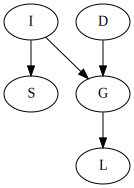

In [3]:
def student_graph():
    '''
    Daggity equivalent:
    dag {
        D [exposure,pos="0.196,0.095"]
        G [pos="0.367,0.272"]
        I [pos="0.524,0.098"]
        L [outcome,pos="0.365,0.431"]
        S [pos="0.706,0.244"]
        D -> G
        G -> L
        I -> G
        I -> S
    }
    '''
    G = nx.DiGraph()
    for n in ['D','I','G','S','L']:
        G.add_node(n)
        
    G.add_edges_from([('D', 'G'),('I', 'G'),('I', 'S'),('G', 'L')])
    return G

# Expect L is unreachable from S given G.
# Expect nothing is unreachable from S given L.
# Expect S and I unreachable from D given nothing.
G = student_graph()
for X,Y,Z in [('S', ['L'], ['G']),
            ('S', [], ['L']),
            ('D', ['S', 'I'], [])]:
    ur = unreachable(G, X=X, Z=Z) 
    assert ur == set(Y)
    
    print X,"⊥",list(ur),'|',Z

nxtogv_draw(G)

In [4]:
def testable_implications(G):
    independencies = set()
    
    Zs = [[z] for z in G.nodes()]
    Zs.insert(0, [])
    
    for x in G.nodes_iter():
        for Z in Zs:
            if len(Z) > 0 and Z[0] == x:
                continue
            
            for y in unreachable(G, X=x, Z=Z):
                if y not in Z and tuple(sorted([x,y])) not in independencies:
                    independencies.add(tuple(sorted([x,y]) + Z))
                    
    return sorted(independencies)

for t in sorted(testable_implications(G=student_graph())):
    ind = t[0] + " ⊥ " + t[1]
    if len(t) == 3:
        ind += ' | ' + t[2]
    print ind

D ⊥ I
D ⊥ L | G
D ⊥ S
G ⊥ S | I
I ⊥ L | G
L ⊥ S | G
L ⊥ S | I
